In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
# Potenziale a cappello messicano
def Vpot(x):
    return (x**2 - 2.5)*x**2
# Potenziale armonico
def Vharm(x):
    return 0.5*x**2
# Somma di gaussiane che approssima il ground state vero, con parametri trovati 
# nell'esercizio sul variational MC (mean = 0.8, sigma = 0.62)
def variat(x):
    return 1/math.sqrt(0.62**2 * math.pi * (2 + math.exp(-0.8**2/0.62**2))
                      )*(np.exp(-0.5*(x-0.8)**2/0.62**2) + np.exp(-0.5*(x+0.8)**2/0.62**2))
# Funzione gaussiana
def gauss(x):
    return np.exp(-0.5*x**2)*1/math.sqrt(2*math.pi)


### Soluzione esatta del problema

In questo paragrafo sfruttiamo il metodo di discretizzazione presentato nella consegna dell'esercizio per risolvere il problema di una particella quantistica in 1 dimensione soggetta a:
- un potenziale a cappello messicano $V(x) = x^4 - \frac{5}{2} x^2$
- un potenziale armonico $V(x) = \frac{1}{2} x^2$

Nel seguito, parlando di risultati "esatti", ci si riferirà a questi.

In [2]:
hbar = 1
m = 1
a = 10
N = 1000 # number of iterations
# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)
Vh = Vharm(x)
# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)
H_harm = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(Vh)
# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)
E_harm, psi_harm = np.linalg.eigh(H_harm)
# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

psi_harm = np.transpose(psi_harm)
psi_harm = psi_harm/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

Ground state energy:  -0.46046587969271563
1st excited state energy:  0.09742471331760998
2nd excited state energy:  1.971733134393021


## Calcolo degli overlap e degli elementi di matrice

In questa fase, come spiegato nel $\textit{j.n.-"PIGS & PIMC"}$, confrontiamo i risultati esatti con quelli ricavati tramite il calcolo PIGS. 

### Cappello Messicano

In [7]:
# Calcolo le due funzioni di partenza
var = variat(x) # Somma di gaussiane
gau = gauss(x) # Gaussiana

# Numero di funzioni d'onda esatte che considereremo nel calcolo dei termini correttivi
label = 12 # può essere aumentato, ma attenzione a cosa succede quando è troppo basso (< 4, 5)

# Elementi di matrice del potenziale sugli stati esatti
potential_matrix = np.zeros((label,label)) 

N = len(x//dx)
# Calcolo gli elementi della matrice del potenziale
for j in range(label):
    for k in range(j+1):
        for i in range(N):
            potential_matrix[j][k] += psi[j][i]*psi[k][i]*V[i]*abs(dx)

# Calcolo gli overlap delle funzioni d'onda esatte con i tre possibili stati di partenza 
# (Ci si aspetta che gli overlap con la funzione variational MC, essendo questa
# simile al GS, siano tutti prossimi a 0)
overlap = np.zeros((3,label))
for j in range(label):
    for i in range(N):
        overlap[0][j] += abs(dx)*psi[j][i]          #overlap con la costante = 1
        overlap[1][j] += abs(dx)*psi[j][i]*gau[i]   #overlap con la gaussiana
        overlap[2][j] += abs(dx)*psi[j][i]*var[i]   #overlap con la fnzione d'onda approssimata

print("                                 ****** OVERLAPS *******")
for i in range(label):
    print("<constant|"+str(i)+"> = ", overlap[0][i],
          "          <gaussian|"+str(i)+"> = ", overlap[1][i])
    #print("<gaussian|"+str(i)+"> = ", overlap[1][i])
    #print("<variationalMC|"+str(i)+"> = ", overlap[2][i])

#print("\n OFF DIAGONAL POTENTIAL ELEMENTS")
#for j in range(label):
    #for k in range(j+1):
        #print("<"+str(j)+"|V|"+str(k)+"> = ", potential_matrix[j][k])

                                 ****** OVERLAPS *******
<constant|0> =  1.905979083005118           <gaussian|0> =  0.5153870360041708
<constant|1> =  1.5990555510381598e-13           <gaussian|1> =  2.6794150251289946e-14
<constant|2> =  0.39220168740875755           <gaussian|2> =  -0.11616994869740856
<constant|3> =  1.0956498651971097e-13           <gaussian|3> =  4.954816470429068e-14
<constant|4> =  -0.6789732094022702           <gaussian|4> =  -0.04921446863409657
<constant|5> =  3.8444630628142446e-14           <gaussian|5> =  1.181162097742986e-14
<constant|6> =  0.5998802965824961           <gaussian|6> =  0.016906794051972127
<constant|7> =  -3.296847806167129e-15           <gaussian|7> =  7.988310793217197e-16
<constant|8> =  -0.5589072241812757           <gaussian|8> =  -0.012141511490756783
<constant|9> =  -3.147838943963539e-14           <gaussian|9> =  -2.949164438552247e-15
<constant|10> =  -0.5257517164956665           <gaussian|10> =  -0.007908407428747943
<constant

Notare in particolare come gli overlap tra autostati esatti $|n\rangle$ e funzione costante (=1) siano sistematicamente più grandi di quelli con la gaussiana, almeno per $n \geq 4 $.

Plottiamo quindi la funzione corrispondente al calcolo PIGS del potenziale, ovvero l'elemento di matrice misto (per la notazione vedi il $\textit{j.n.-"PIGS & PIMC"}$)
$$
\langle V(\lambda) \rangle = \frac{\langle \psi_0 | e^{-\hat H  \lambda }\hat V e^{-\hat H (2\tau-\lambda) }| \psi_0 \rangle}{\langle \psi(\tau) | \psi(\tau) \rangle} \tag{1}
$$ 
al variare di $\lambda$ e per 3 diverse funzioni di partenza.

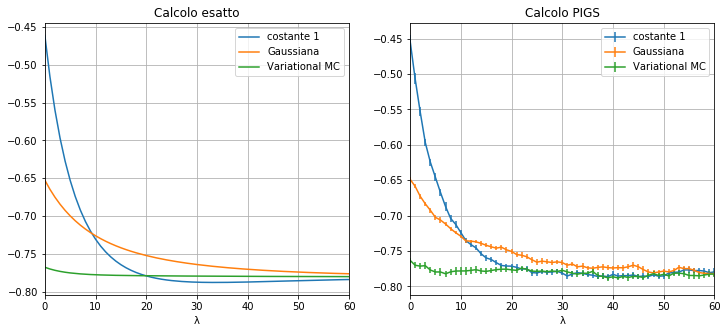

In [8]:
N = np.arange(0,450) # N gioca il ruolo di lambda
r = len(N)
tau = 8 # stesso parametro usato nel PIGS
num = np.zeros((3, r))
text = ['costante 1', 'Gaussiana', 'Variational MC']
file = ['const', 'gauss', 'var']

f = plt.figure(figsize = (12,5))

# In un unico ciclo effettuo il calcolo e plotto i risultati
for l in range(3):
    # Calcolo la funzione (1)
    for j in range(label):
        for k in range(j+1):
            app = (overlap[l][j]*overlap[l][k]/overlap[l][0]**2)*potential_matrix[j][k]*(
            np.exp(- tau*(E[j]-E[k])*N/450- tau*(E[k]-E[0])) + 
            np.exp(- tau*(E[k]-E[j])*N/450 - tau*(E[j]-E[0])))
            if k ==j: 
                num[l] += app/2
            else:
                num[l] += app
    # Plotto i risultati del calcolo esatto
    f.add_subplot(1, 2, 1)
    plt.plot(N, num[l], label = text[l])
    plt.xlim(0, 60)
    plt.xlabel('\u03BB')
    plt.title('Calcolo esatto')
    plt.grid()
    plt.legend()
    
    # Plotto i risultati del calcolo PIGS
    timeslice, ave_pot, err_pot = np.loadtxt("Output_PIGS/potential."+file[l]+".dat", 
                                usecols = (0,1,2), unpack = 'true')
    f.add_subplot(1, 2, 2)
    plt.errorbar(timeslice, ave_pot, err_pot, label = text[l])
    plt.xlim(0,60)
    plt.xlabel('\u03BB')
    plt.title('Calcolo PIGS')
    plt.grid()
    plt.legend()


Gli overlap della funzione costate con gli autostati esatti causano una proiezione rapida della prima sul ground state. Addirittura l'energia va sotto la soglia di -0.78 a causa di queste correzioni.

### Potenziale armonico

Il procedimento è identico, utilizzo solo funzioni diverse per il potenziale e per gli autostati esatti. Notare che la gaussiana è già il ground state esatto quindi il valor medio $(1)$ non cambia al variare di $\lambda$.

                                 ****** OVERLAPS *******
<constant|0> =  1.8827859105904754           <variational|0> =  0.9684950024875095
<constant|1> =  -1.7151595732656057e-13           <variational|1> =  -6.486238790208391e-14
<constant|2> =  -1.3312352953879458           <variational|2> =  -0.1528575781326296
<constant|3> =  -1.2980721995500428e-13           <variational|3> =  -3.7367814265276314e-14
<constant|4> =  1.15169628530894           <variational|4> =  -0.14681736694118927
<constant|5> =  2.3865831381115836e-13           <variational|5> =  -2.3533004068075996e-14
<constant|6> =  -1.0417237681734361           <variational|6> =  -0.07026519130279658
<constant|7> =  1.4736497612466426e-13           <variational|7> =  8.639835953612277e-15
<constant|8> =  0.927343135221042           <variational|8> =  -0.026774763409435548
<constant|9> =  -2.9124833512798876e-13           <variational|9> =  1.6572078650753062e-15
<constant|10> =  -0.7549390952969154           <variational|10

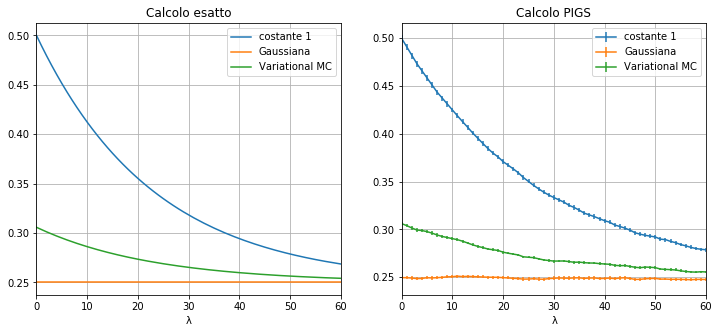

In [9]:
label = 12

overlap = np.zeros((3,label))
potential_matrix = np.zeros((label,label)) 

N = len(x//dx)
for j in range(label):
    for k in range(j+1):
        for i in range(N):
            potential_matrix[j][k] += psi_harm[j][i]*psi_harm[k][i]*Vh[i]*abs(dx)

for j in range(label):
    for i in range(N):
        overlap[0][j] += abs(dx)*psi_harm[j][i]
        overlap[1][j] += abs(dx)*psi_harm[j][i]*gau[i]
        overlap[2][j] += abs(dx)*psi_harm[j][i]*var[i]

print("                                 ****** OVERLAPS *******")
for i in range(label):
    print("<constant|"+str(i)+"> = ", overlap[0][i],
          "          <variational|"+str(i)+"> = ", overlap[2][i])
    #print("<gauss|"+str(i)+"> = ", overlap[1][i])
    #print("<variationalMC|"+str(i)+"> = ", overlap[2][i])

#print("\n OFF DIAGONAL POTENTIAL ELEMENTS")
#for j in range(label):
    #for k in range(j+1):
        #print("<"+str(j)+"|V|"+str(k)+"> = ", potential_matrix[j][k])
N = np.arange(0,450) # N gioca il ruolo di lambda
r = len(N)
tau = 8 # stesso parametro usato nel PIGS
num = np.zeros((3, r))
text = ['costante 1', 'Gaussiana', 'Variational MC']
file = ['const', 'gauss', 'var']

f = plt.figure(figsize = (12,5))

# In un unico ciclo effettuo il calcolo e plotto i risultati
for l in range(3):
    # Calcolo la funzione (1)
    for j in range(label):
        for k in range(j+1):
            app = (overlap[l][j]*overlap[l][k]/overlap[l][0]**2)*potential_matrix[j][k]*(
            np.exp(- tau*(E[j]-E[k])*N/450- tau*(E[k]-E[0])) + 
            np.exp(- tau*(E[k]-E[j])*N/450 - tau*(E[j]-E[0])))
            if k ==j: 
                num[l] += app/2
            else:
                num[l] += app
    # Plotto i risultati del calcolo esatto
    f.add_subplot(1, 2, 1)
    plt.plot(N, num[l], label = text[l])
    plt.xlim(0, 60)
    plt.xlabel('\u03BB')
    plt.title('Calcolo esatto')
    plt.grid()
    plt.legend()
    
    # Plotto i risultati del calcolo PIGS
    timeslice, ave_pot, err_pot = np.loadtxt("Output_PIGS/harmonic."+file[l]+".dat", 
                                usecols = (0,1,2), unpack = 'true')
    f.add_subplot(1, 2, 2)
    plt.errorbar(timeslice, ave_pot, err_pot, label = text[l])
    plt.xlim(0,60)
    plt.xlabel('\u03BB')
    plt.title('Calcolo PIGS')
    plt.grid()
    plt.legend()